In [1]:
import json
import os
import os.path
import matplotlib.pyplot as plt
import numpy as np
import glob
import copy
import shutil
import random
import os.path

from copy import deepcopy
from os.path import exists, join
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
FEATURES_FOLDER = '/home/cdragancea/FBACode/analyze'


In [3]:
# load the outputs from the analyze/ folder
stats = dict()
analyze_summary = dict()

with open(f"{FEATURES_FOLDER}/analyze_summary.json", "r") as fin:
    analyze_summary = json.load(fin)

counter = 0
for project_name in os.listdir(FEATURES_FOLDER):
    # print(f"Loading overall_stats for {project_name}")
    # if project_name == "analyze_summary.json":
    if project_name == "analyze_summary.json" or project_name == "analyze_summary2.json":
        continue
    if not exists(join(FEATURES_FOLDER, project_name, 'overall_stats')) or project_name not in analyze_summary:
        print(f"Skipping {project_name} because it does not have overall_stats.")
        counter += 1
        # if project_name in analyze_summary:
        #     analyze_summary.pop(project_name)
        # shutil.rmtree(join(FEATURES_FOLDER, project_name), ignore_errors=True)
        continue
    if analyze_summary[project_name]["analysis"] != "success":
        continue

    with open(join(FEATURES_FOLDER, project_name, 'overall_stats')) as f:
        content = f.read()
    try:
        overall_stats = json.loads(content)
    except json.JSONDecodeError as e:
        str_err = str(e)
        line = int(str_err.split()[3]) - 1
    
    individual_features = json.loads('\n'.join(content.split('\n')[:line]))
    overall_features = json.loads('\n'.join(content.split('\n')[line:]))
    stats[project_name] = {
        'individual_features': individual_features,
        'overall_features': overall_features
    }

project_names = list(stats.keys())
# with open(f"{FEATURES_FOLDER}/analyze_summary2.json", "w") as fout:
#     fout.write(json.dumps(analyze_summary, indent=4))

Skipping eclib because it does not have overall_stats.
Skipping kalarm because it does not have overall_stats.
Skipping r-cran-leidenbase because it does not have overall_stats.
Skipping qdmr because it does not have overall_stats.
Skipping kdb because it does not have overall_stats.
Skipping kmail because it does not have overall_stats.
Skipping libcec because it does not have overall_stats.
Skipping libffado because it does not have overall_stats.
Skipping akonadi-notes because it does not have overall_stats.
Skipping dolphin because it does not have overall_stats.


In [4]:
archive_sizes = dict()
with open("/home/cdragancea/FBACode/archive_sizes.json", "r") as fin:
    archive_sizes = json.load(fin)

In [5]:
ast_numbers = []
size_statistics = dict()

for project in analyze_summary:
    if analyze_summary[project]["analysis"] == "success":
        ast_numbers.append(analyze_summary[project]["size_statistics"]["nr_ast_files"])
        size_statistics[project] = analyze_summary[project]["size_statistics"]
        
        size_statistics[project]["archive_size"] = archive_sizes[project]

ast_numbers = sorted(ast_numbers, reverse=True)

print(len(size_statistics.keys()))

print(f"Nr or projects with 0 ASTs: {len([x for x in ast_numbers if x == 0])}")


4365
Nr or projects with 0 ASTs: 496


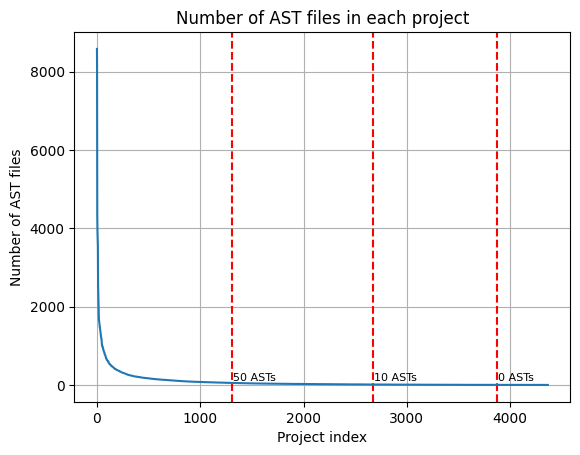

In [6]:
# plot ast_numbers
def plot_ast_numbers(ast_numbers):
    plt.figure()

    first_0 = ast_numbers.index(0)
    first_10 = ast_numbers.index(10)
    first_50 = ast_numbers.index(50)

    plt.axvline(x = first_0, color='r', linestyle='--')
    plt.text(first_0 + 10, 100, '0 ASTs', color='black', fontsize=8, ha='left')

    plt.axvline(x = first_10, color='r', linestyle='--')
    plt.text(first_10 + 10, 100, '10 ASTs', color='black', fontsize=8, ha='left')

    plt.axvline(x = first_50, color='r', linestyle='--')
    plt.text(first_50 + 10, 100, '50 ASTs', color='black', fontsize=8, ha='left')

    plt.plot(ast_numbers)
    plt.xlabel("Project index")
    plt.ylabel("Number of AST files")
    plt.title("Number of AST files in each project")
    plt.grid(True)
    plt.show()

plot_ast_numbers(ast_numbers)

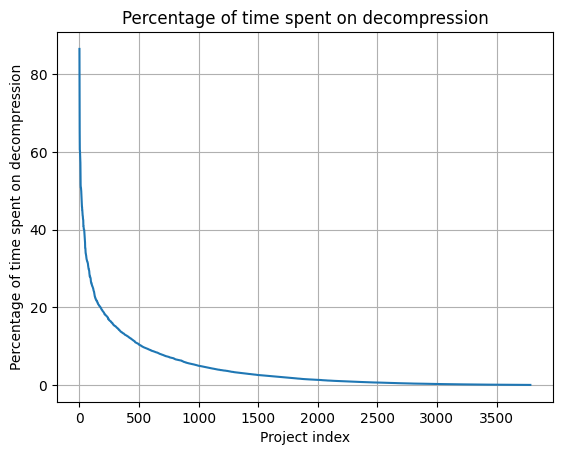

Total decompression time: 80917.13103723526
Total analysis time: 615122.6048104763
Percentage of time spent on decompression: 13.154634605269694


In [7]:
AST_NR_CUTOFF = 4 * 36

# Percentage of time spent on decompression
def plot_decompression_time(size_statistics):
    plt.figure()

    decompression_perc = []
    for project in stats:
        if size_statistics[project]["nr_ast_files"] > AST_NR_CUTOFF:
            continue
        decompression_perc.append(size_statistics[project]["decompression_time"] / size_statistics[project]["total_analysis_time"] * 100)

    decompression_perc = sorted(decompression_perc, reverse=True)

    plt.plot(decompression_perc)
    plt.xlabel("Project index")
    plt.ylabel("Percentage of time spent on decompression")
    plt.title("Percentage of time spent on decompression")
    plt.grid(True)
    plt.show()

plot_decompression_time(size_statistics)

total_decompression_time = sum([size_statistics[project]["decompression_time"] for project in size_statistics])
total_analysis_time = sum([size_statistics[project]["total_analysis_time"] for project in size_statistics])
print(f"Total decompression time: {total_decompression_time}")
print(f"Total analysis time: {total_analysis_time}")
print(f"Percentage of time spent on decompression: {total_decompression_time / total_analysis_time * 100}")

R^2: 0.04913063930699513


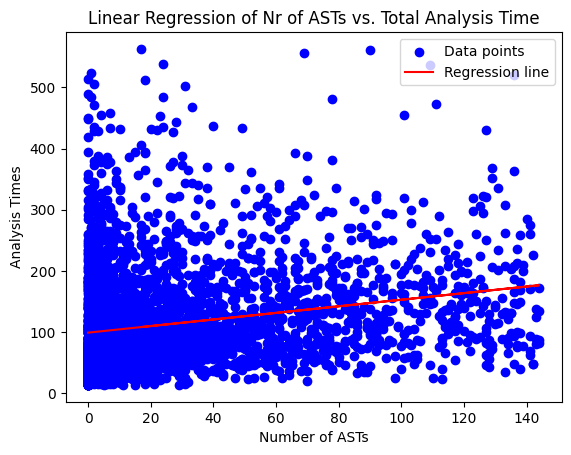

In [23]:
# Plotting analysis time vs number of ASTs

def total_analysis_time_VS_nr_ast_files(size_statistics):
    # Sample data
    packed_data = [(project['nr_ast_files'], project['total_analysis_time']) for project in size_statistics.values() if project['nr_ast_files'] <= AST_NR_CUTOFF]

    # removing some outliers on both dimensions
    packed_data = sorted(packed_data, key=lambda x: x[0])
    packed_data = packed_data[:-5]

    packed_data = sorted(packed_data, key=lambda x: x[1])
    packed_data = packed_data[:-5]


    binary_sizes = np.array([x[0] for x in packed_data])
    analysis_times = np.array([x[1] for x in packed_data])


    # Reshape the data
    X = binary_sizes.reshape(-1, 1)
    y = analysis_times

    # Create and fit the model
    model = LinearRegression()
    model.fit(X, y)

    # Make predictions
    y_pred = model.predict(X)

    # Calculate R^2 (coefficient of determination)
    r2 = r2_score(y, y_pred)
    print(f'R^2: {r2}')

    # Plot the results
    plt.scatter(binary_sizes, analysis_times, color='blue', label='Data points')
    plt.plot(binary_sizes, y_pred, color='red', label='Regression line')
    plt.xlabel('Number of ASTs')
    plt.ylabel('Analysis Times')
    plt.title('Linear Regression of Nr of ASTs vs. Total Analysis Time')
    plt.legend()
    plt.show()

total_analysis_time_VS_nr_ast_files(size_statistics)


R^2: 0.1334228569128224


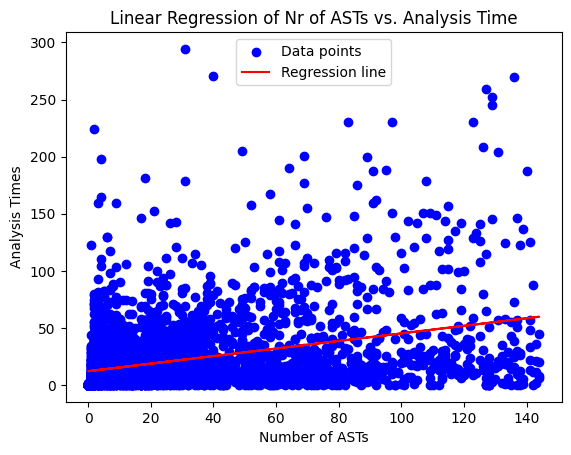

In [24]:
# Plotting analysis time vs number of ASTs

def analysis_time_VS_nr_ast_files(size_statistics):
    # Sample data
    packed_data = [(project['nr_ast_files'], project['analyze_features_time'] + project['emit_statistics_time']) for project in size_statistics.values() if project['nr_ast_files'] <= AST_NR_CUTOFF]

    # removing some outliers on both dimensions
    packed_data = sorted(packed_data, key=lambda x: x[0])
    packed_data = packed_data[:-5]

    packed_data = sorted(packed_data, key=lambda x: x[1])
    packed_data = packed_data[:-5]
    
    binary_sizes = np.array([x[0] for x in packed_data])
    analysis_times = np.array([x[1] for x in packed_data])


    # Reshape the data
    X = binary_sizes.reshape(-1, 1)
    y = analysis_times

    # Create and fit the model
    model = LinearRegression()
    model.fit(X, y)

    # Make predictions
    y_pred = model.predict(X)

    # Calculate R^2 (coefficient of determination)
    r2 = r2_score(y, y_pred)
    print(f'R^2: {r2}')

    # Plot the results
    plt.scatter(binary_sizes, analysis_times, color='blue', label='Data points')
    plt.plot(binary_sizes, y_pred, color='red', label='Regression line')
    plt.xlabel('Number of ASTs')
    plt.ylabel('Analysis Times')
    plt.title('Linear Regression of Nr of ASTs vs. Analysis Time')
    plt.legend()
    plt.show()

analysis_time_VS_nr_ast_files(size_statistics)


R^2: 0.10345510389650725


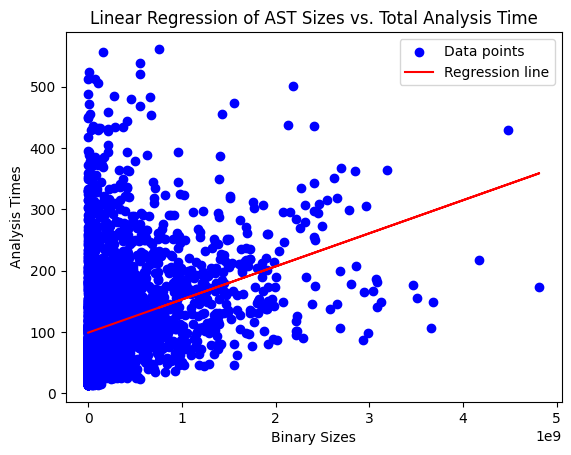

In [25]:
# Plotting analysis time vs ast size

def total_analysis_time_VS_ast_size(size_statistics):
    # Sample data
    packed_data = [(project['ast_size'], project['total_analysis_time']) for project in size_statistics.values() if project['nr_ast_files'] <= AST_NR_CUTOFF]
    
    # removing some outliers on both dimensions
    packed_data = sorted(packed_data, key=lambda x: x[0])
    packed_data = packed_data[:-5]

    packed_data = sorted(packed_data, key=lambda x: x[1])
    packed_data = packed_data[:-5]

    binary_sizes = np.array([x[0] for x in packed_data])
    analysis_times = np.array([x[1] for x in packed_data])


    # Reshape the data
    X = binary_sizes.reshape(-1, 1)
    y = analysis_times

    # Create and fit the model
    model = LinearRegression()
    model.fit(X, y)

    # Make predictions
    y_pred = model.predict(X)

    # Calculate R^2 (coefficient of determination)
    r2 = r2_score(y, y_pred)
    print(f'R^2: {r2}')

    # Plot the results
    plt.scatter(binary_sizes, analysis_times, color='blue', label='Data points')
    plt.plot(binary_sizes, y_pred, color='red', label='Regression line')
    plt.xlabel('Binary Sizes')
    plt.ylabel('Analysis Times')
    plt.title('Linear Regression of AST Sizes vs. Total Analysis Time')
    plt.legend()
    plt.show()

total_analysis_time_VS_ast_size(size_statistics)


R^2: 0.2942723473958473


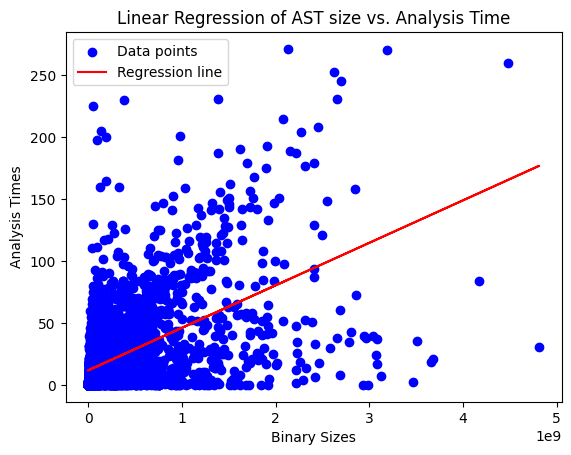

In [26]:
# Plotting analysis time vs size of ASTs

def analysis_time_VS_ast_size(size_statistics):
    # Sample data
    packed_data = [(project['ast_size'], project['analyze_features_time'] + project['emit_statistics_time']) for project in size_statistics.values() if project['nr_ast_files'] <= AST_NR_CUTOFF]

    # removing some outliers on both dimensions
    packed_data = sorted(packed_data, key=lambda x: x[0])
    packed_data = packed_data[:-5]

    packed_data = sorted(packed_data, key=lambda x: x[1])
    packed_data = packed_data[:-5]
    
    binary_sizes = np.array([x[0] for x in packed_data])
    analysis_times = np.array([x[1] for x in packed_data])


    # Reshape the data
    X = binary_sizes.reshape(-1, 1)
    y = analysis_times

    # Create and fit the model
    model = LinearRegression()
    model.fit(X, y)

    # Make predictions
    y_pred = model.predict(X)

    # Calculate R^2 (coefficient of determination)
    r2 = r2_score(y, y_pred)
    print(f'R^2: {r2}')

    # Plot the results
    plt.scatter(binary_sizes, analysis_times, color='blue', label='Data points')
    plt.plot(binary_sizes, y_pred, color='red', label='Regression line')
    plt.xlabel('Binary Sizes')
    plt.ylabel('Analysis Times')
    plt.title('Linear Regression of AST size vs. Analysis Time')
    plt.legend()
    plt.show()

analysis_time_VS_ast_size(size_statistics)


R^2: 0.27844560283246256


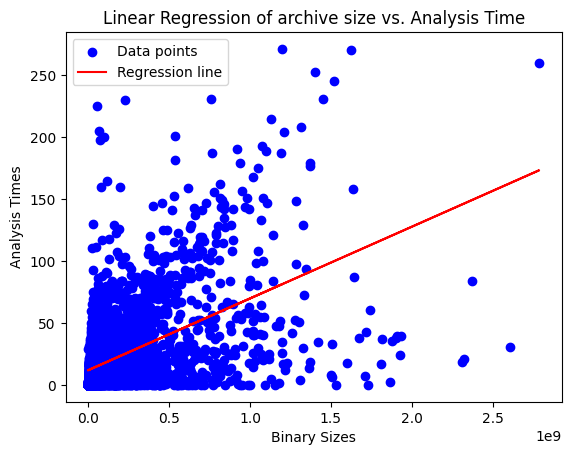

In [27]:
# analysis time vs archive size

def analysis_time_VS_archive_size(size_statistics):
    # Sample data
    packed_data = [(project['archive_size'], project['analyze_features_time'] + project['emit_statistics_time']) for project in size_statistics.values() if project['nr_ast_files'] <= AST_NR_CUTOFF]

    # removing some outliers on both dimensions
    packed_data = sorted(packed_data, key=lambda x: x[0])
    packed_data = packed_data[:-5]

    packed_data = sorted(packed_data, key=lambda x: x[1])
    packed_data = packed_data[:-5]
    
    binary_sizes = np.array([x[0] for x in packed_data])
    analysis_times = np.array([x[1] for x in packed_data])


    # Reshape the data
    X = binary_sizes.reshape(-1, 1)
    y = analysis_times

    # Create and fit the model
    model = LinearRegression()
    model.fit(X, y)

    # Make predictions
    y_pred = model.predict(X)

    # Calculate R^2 (coefficient of determination)
    r2 = r2_score(y, y_pred)
    print(f'R^2: {r2}')

    # Plot the results
    plt.scatter(binary_sizes, analysis_times, color='blue', label='Data points')
    plt.plot(binary_sizes, y_pred, color='red', label='Regression line')
    plt.xlabel('Binary Sizes')
    plt.ylabel('Analysis Times')
    plt.title('Linear Regression of archive size vs. Analysis Time')
    plt.legend()
    plt.show()

analysis_time_VS_archive_size(size_statistics)

R^2: 0.11758304732605318


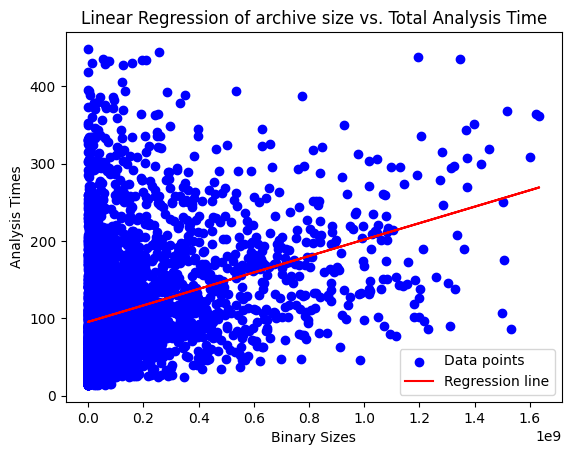

In [28]:
# analysis time vs archive size

def total_analysis_time_VS_archive_size(size_statistics):
    # Sample data
    packed_data = [(project['archive_size'], project['total_analysis_time']) for project in size_statistics.values() if project['nr_ast_files'] <= AST_NR_CUTOFF]

    # removing some outliers on both dimensions
    packed_data = sorted(packed_data, key=lambda x: x[0])
    packed_data = packed_data[:-25]

    packed_data = sorted(packed_data, key=lambda x: x[1])
    packed_data = packed_data[:-25]
    
    binary_sizes = np.array([x[0] for x in packed_data])
    analysis_times = np.array([x[1] for x in packed_data])


    # Reshape the data
    X = binary_sizes.reshape(-1, 1)
    y = analysis_times

    # Create and fit the model
    model = LinearRegression()
    model.fit(X, y)

    # Make predictions
    y_pred = model.predict(X)

    # Calculate R^2 (coefficient of determination)
    r2 = r2_score(y, y_pred)
    print(f'R^2: {r2}')

    # Plot the results
    plt.scatter(binary_sizes, analysis_times, color='blue', label='Data points')
    plt.plot(binary_sizes, y_pred, color='red', label='Regression line')
    plt.xlabel('Binary Sizes')
    plt.ylabel('Analysis Times')
    plt.title('Linear Regression of archive size vs. Total Analysis Time')
    plt.legend()
    plt.show()

total_analysis_time_VS_archive_size(size_statistics)

In [29]:
filtered_projects = {pname: x for pname, x in analyze_summary.items() if x['size_statistics'].get('nr_ast_files', 0) > 0 and x['size_statistics']['total_analysis_time'] < 60}

print(len(filtered_projects))
print(random.sample(list(filtered_projects), 5))


717
['nxtrim', 'kamera', 'vpb-driver', 'muparserx', 'intel2gas']


In [30]:
overall_analysis_time = sum([x['size_statistics']['total_analysis_time'] for x in analyze_summary.values()])
print(overall_analysis_time)

longest_analysis_time = sorted([(x['size_statistics']['total_analysis_time'], pname) for pname, x in analyze_summary.items()], key = lambda x: x[0], reverse = True)
print(longest_analysis_time[:5])
# 615k seconds, this is with mostly 16 jobs for langstat, running in parallel
# On einstein it takes ~30 hours to run this stuff
# Let's say i want the results in 2 hours? Let's use an array of 15 jobs.
# Need to split the projects into 15 bins

# "heavy" jobs: many ASTs, > 50
# "mid" jobs: 10 < ASTs < 50
# "light" jobs: 0 < ASTs < 10

# For light jobs, run them on nodes, with 36 process pools, and 1/2 jobs for langstat
# For heavy nodes, run them on nodes with 1 process in the pool, but 36 (or more) jobs for langstat
# For mid jobs, idk. 9 processes in the pool, 4-6 jobs for langstat.


615363.2370033264
[(5287.9444670677185, 'suitesparse-graphblas'), (4189.225914955139, 'pypy3'), (3017.7901883125305, 'openmpi'), (2804.7400476932526, 'mpich'), (2401.12189078331, 'blis')]


In [31]:
print(615_000 / (60 * 60))

170.83333333333334


In [32]:
job_distribution_by_weight = {
    "light": [],
    "mid": [],
    "heavy": []
}
job_distribution_nodes_by_weight = {
    "light": 4,
    "mid": 0,
    "heavy": 40
}

# let's try with a small subset first
size_statistics_as_list = list(size_statistics.items())
# size_statistics_as_list = random.sample(size_statistics_as_list, 500)
size_statistics_as_list = random.sample(size_statistics_as_list, len(size_statistics_as_list))
size_statistics = dict(size_statistics_as_list)

for project_name, project in size_statistics.items():
    if project.get('nr_ast_files', 0) > 36 * 4:
        job_distribution_by_weight["heavy"].append((project_name, project))
    # elif 25 < project.get('nr_ast_files', 0) <= 36 * 3:
    #     job_distribution_by_weight["mid"].append(project_name)
    else:
        job_distribution_by_weight["light"].append((project_name, project))


In [33]:
print([(x, len(job_distribution_by_weight[x])) for x in job_distribution_by_weight])

[('light', 3789), ('mid', 0), ('heavy', 576)]


In [34]:
def bin_pack_by_ast_archive_size(jobs, nr_of_bins):
    bins = [[] for _ in range(nr_of_bins)]
    bin_weights = [0 for _ in range(nr_of_bins)]

    for job in jobs:
        min_bin = bin_weights.index(min(bin_weights))
        bins[min_bin].append(job[0])
        bin_weights[min_bin] += size_statistics[job]['archive_size']

    print(bin_weights)

    min_val = np.min(bin_weights)
    max_val = np.max(bin_weights)
    scaled_data = (bin_weights - min_val) / (max_val - min_val)

    mean = np.mean(bin_weights)
    std_dev = np.std(bin_weights)
    scaled_data = (bin_weights - mean) / std_dev
    
    print(scaled_data)
    return bins


def bin_packing_by_time(jobs, nr_of_bins):
    if len(jobs) == 0:
        return [[] for _ in range(nr_of_bins)]
    # jobs = list(analyze_summary.items())
    # jobs = sorted(jobs, key=lambda x: x[1]['size_statistics']['total_analysis_time'], reverse=True)

    bins = [[] for _ in range(nr_of_bins)]
    bin_weights = [0 for _ in range(nr_of_bins)]

    for job in jobs:
        min_bin = bin_weights.index(min(bin_weights))
        bins[min_bin].append(job[0])
        bin_weights[min_bin] += job[1]['total_analysis_time']

    print(bin_weights)

    min_val = np.min(bin_weights)
    max_val = np.max(bin_weights)
    scaled_data = (bin_weights - min_val) / (max_val - min_val)

    # mean = np.mean(bin_weights)
    # std_dev = np.std(bin_weights)
    # scaled_data = (bin_weights - mean) / std_dev
    
    print(scaled_data)
    return bins

# heavy_jobs = bin_pack_by_ast_archive_size(job_distribution_by_weight["heavy"], job_distribution_nodes_by_weight["heavy"])
heavy_jobs = bin_packing_by_time(job_distribution_by_weight["heavy"], job_distribution_nodes_by_weight["heavy"])
mid_jobs = bin_packing_by_time(job_distribution_by_weight["mid"], job_distribution_nodes_by_weight["mid"])
light_jobs = bin_packing_by_time(job_distribution_by_weight["light"], job_distribution_nodes_by_weight["light"])
# mid_jobs = bin_pack_by_ast_archive_size(job_distribution_by_weight["mid"], job_distribution_nodes_by_weight["mid"])
# light_jobs = bin_pack_by_ast_archive_size(job_distribution_by_weight["light"], job_distribution_nodes_by_weight["light"])

[5821.470556259155, 4981.479065418243, 4323.690457344055, 4289.708888292313, 4373.871375083923, 5104.493021965027, 4144.293584346771, 4729.455723762512, 4089.593517780304, 4186.625353574753, 4276.170339584351, 4447.933160305023, 4220.86811709404, 4317.206632375717, 4164.361166715622, 4407.413271665573, 4211.277424097061, 4552.8818900585175, 4178.778555631638, 4254.3556752204895, 4261.755954504013, 4380.741924285889, 6961.6247227191925, 5019.924060583115, 4422.739030599594, 4101.968946218491, 5918.066559314728, 4122.606722831726, 4179.007825613022, 4137.025807857513, 4375.805663585663, 4129.485226154327, 4274.7269718647, 4189.225914955139, 4511.72661280632, 4421.051982164383, 4235.171725034714, 4175.570206403732, 4374.4590792655945, 4389.827215194702]
[0.6030147  0.31054173 0.08150919 0.0696773  0.09898147 0.35337343
 0.01904578 0.22279083 0.         0.03378509 0.06496337 0.12476871
 0.04570793 0.07925162 0.02603302 0.11066027 0.04236859 0.16131035
 0.03105295 0.05736782 0.05994449 0.10

In [35]:
job_distribution = dict()

idx = 1
for count in range(job_distribution_nodes_by_weight["heavy"]):
    job_distribution[idx] = dict()
    job_distribution[idx]["jobs"] = heavy_jobs[count]
    job_distribution[idx]["process_pool_size"] = 1
    job_distribution[idx]["jobs_for_langstat"] = 60
    job_distribution[idx]["job_type"] = "heavy"
    idx += 1
for count in range(job_distribution_nodes_by_weight["mid"]):
    job_distribution[idx] = dict()
    job_distribution[idx]["jobs"] = mid_jobs[count]
    job_distribution[idx]["process_pool_size"] = 12
    job_distribution[idx]["jobs_for_langstat"] = 4
    job_distribution[idx]["job_type"] = "mid"
    idx += 1
for count in range(job_distribution_nodes_by_weight["light"]):
    job_distribution[idx] = dict()
    job_distribution[idx]["jobs"] = light_jobs[count]
    job_distribution[idx]["process_pool_size"] = 20
    job_distribution[idx]["jobs_for_langstat"] = 3
    job_distribution[idx]["job_type"] = "light"
    idx += 1

with open("/home/cdragancea/FBACode/job_distribution.json", "w") as fout:
    fout.write(json.dumps(job_distribution, indent=4))

In [36]:
print(len([x for x in analyze_summary.values() if x['size_statistics'].get('nr_ast_files', 0) < 3 * 36]))
print(len([x for x in analyze_summary.values() if x['size_statistics'].get('nr_ast_files', 0) > 3 * 36]))
print(sum([x['size_statistics']['total_analysis_time'] for x in analyze_summary.values() if x['size_statistics'].get('nr_ast_files', 0) < 3 * 36]) / 36)

3602
761
11211.00544959969


In [37]:
def count_light_jobs(job_distribution):
    return sum([len(job_distribution[x]["jobs"]) for x in job_distribution if job_distribution[x]["job_type"] == "light"])

count_light_jobs(job_distribution)

3789

In [38]:
size_statistics['vtk9']

{'decompression_time': 909.7154057025909,
 'nr_ast_files': 8579,
 'nr_bc_files': 8579,
 'ast_size': 63626091048,
 'bc_size': 2234190440,
 'analyze_features_time': 45.29352140426636,
 'emit_statistics_time': 0.3403632640838623,
 'total_analysis_time': 1063.417882680893,
 'archive_size': 38054745814}

In [39]:
jobs = [
            "vtk9",
            "openclonk",
            "twinkle",
            "libbpp-phyl",
            "exult",
            "vips",
            "aws-crt-python",
            "vile"
        ]

for job in jobs:
    print(f"{job} : {size_statistics[job]}")

vtk9 : {'decompression_time': 909.7154057025909, 'nr_ast_files': 8579, 'nr_bc_files': 8579, 'ast_size': 63626091048, 'bc_size': 2234190440, 'analyze_features_time': 45.29352140426636, 'emit_statistics_time': 0.3403632640838623, 'total_analysis_time': 1063.417882680893, 'archive_size': 38054745814}
openclonk : {'decompression_time': 102.15427780151367, 'nr_ast_files': 246, 'nr_bc_files': 246, 'ast_size': 5343758244, 'bc_size': 106279188, 'analyze_features_time': 38.841235637664795, 'emit_statistics_time': 0.05326199531555176, 'total_analysis_time': 186.6260621547699, 'archive_size': 2893444575}
twinkle : {'decompression_time': 42.576967000961304, 'nr_ast_files': 205, 'nr_bc_files': 205, 'ast_size': 2165046520, 'bc_size': 73168620, 'analyze_features_time': 133.50274801254272, 'emit_statistics_time': 24.212373971939087, 'total_analysis_time': 270.59060525894165, 'archive_size': 1228959721}
libbpp-phyl : {'decompression_time': 49.70405030250549, 'nr_ast_files': 181, 'nr_bc_files': 181, 'as